In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(45),
    transforms.ToTensor(), #parse to tensor
    transforms.Resize((128,128)) #Resize to 128x128

])

dataset_train = ImageFolder(
    "clouds/clouds_train",
    transform=train_transform
)
dataloader_train = DataLoader(
    dataset=dataset_train,
    shuffle=True,
    batch_size=1
)


In [7]:
len(dataset_train)

474

### Display images

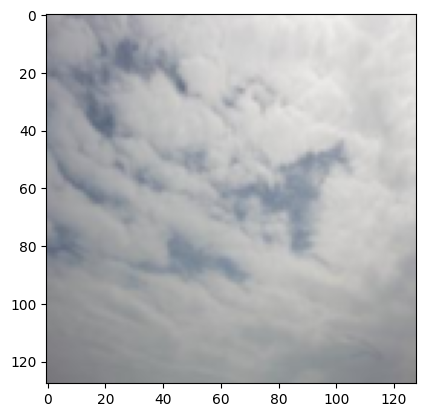

In [16]:
import matplotlib.pyplot as plt
image, label = next(iter(dataloader_train))
image = image.squeeze().permute(1,2,0)
plt.imshow(image)

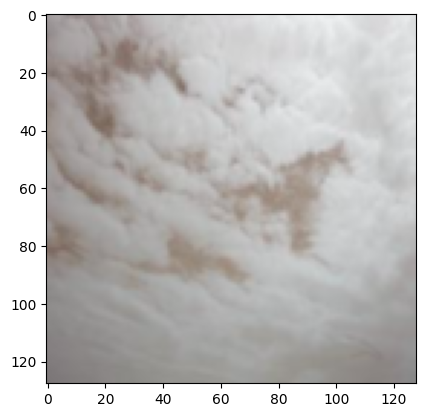

In [51]:
flip = transforms.RandomHorizontalFlip()
image_flip = flip(image)
plt.imshow(image_flip)